In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
import statsmodels.api as sm
import pykalman

In [3]:
data = pd.read_excel(os.getcwd() + "/data/ODMD_MainData.xlsx")
data = data.sort_values(ascending=True,by="Date")
data.loc[data.MARKA == "KG MOBILITY – SSANGYONG",'MARKA'] = "SSANGYONG" 
## 0 olan satıs aylarını cıkar.
data = data[data.TTL_TOPLAM != 0]

## group by Date
monthly_data = data[["Date","TTL_TOPLAM"]].groupby("Date").agg({"TTL_TOPLAM":"sum"}).reset_index()
monthly_data.head(5)

,Date,TTL_TOPLAM
0,2014-01-01,32670
1,2014-02-01,35021
2,2014-03-01,47581
3,2014-04-01,53305
4,2014-05-01,58121


In [4]:
monthly_data = monthly_data.sort_values("Date",ascending= True)
monthly_data

,Date,TTL_TOPLAM
0,2014-01-01,32670
1,2014-02-01,35021
2,2014-03-01,47581
3,2014-04-01,53305
4,2014-05-01,58121
...,...,...
122,2024-03-01,109828
123,2024-04-01,75919
124,2024-05-01,100305
125,2024-06-01,106238


In [5]:
## Shift & MA
monthly_data["Shifted1"] = monthly_data["TTL_TOPLAM"].shift(1)
monthly_data["Shifted3"] = monthly_data["TTL_TOPLAM"].shift(3)
monthly_data["Shifted6"] = monthly_data["TTL_TOPLAM"].shift(6)
monthly_data["Shifted12"] = monthly_data["TTL_TOPLAM"].shift(12)
monthly_data["Shifted1_SMA3"] = monthly_data["TTL_TOPLAM"].shift(1).rolling(3).mean()
monthly_data["Shifted1_SMA6"] = monthly_data["TTL_TOPLAM"].shift(1).rolling(6).mean()
monthly_data["Shifted1_SMA12"] = monthly_data["TTL_TOPLAM"].shift(1).rolling(12).mean()



## Date Features
monthly_data["Month"] = monthly_data.Date.dt.month
monthly_data["Quarter"] = monthly_data.Date.dt.quarter
monthly_data["Year"] = monthly_data.Date.dt.year

In [20]:
kf = pykalman.KalmanFilter(initial_state_mean=monthly_data['Shifted1'].fillna(method = "bfill").values[0],
                  n_dim_obs=1, n_dim_state=1)

# Kalman Filtresini uygulama
filtered_state_means, _ = kf.filter(monthly_data['Shifted1'].fillna(method = "bfill").values)

# Sonuçları DataFrame'e ekleme
monthly_data['Kalman_Filtered'] = filtered_state_means

In [22]:
monthly_data

,Date,TTL_TOPLAM,Shifted1,Shifted3,Shifted6,Shifted12,Shifted1_SMA3,Shifted1_SMA6,Shifted1_SMA12,Month,Quarter,Year,Kalman_Filtered
0,2014-01-01,32670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2014,32670.000000
1,2014-02-01,35021,32670.0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2014,32670.000000
2,2014-03-01,47581,35021.0,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2014,34116.769231
3,2014-04-01,53305,47581.0,32670.0,NaN,NaN,38424.000000,NaN,NaN,4,2,2014,42432.911765
4,2014-05-01,58121,53305.0,35021.0,NaN,NaN,45302.333333,NaN,NaN,5,2,2014,49151.617978
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,2024-03-01,109828,105990.0,158653.0,96793.0,103929.0,114781.333333,109590.666667,107190.333333,3,1,2024,104713.067688
123,2024-04-01,75919,109828.0,79701.0,101367.0,97679.0,98506.333333,111763.166667,107681.916667,4,2,2024,107874.269707
124,2024-05-01,100305,75919.0,105990.0,115040.0,111556.0,97245.666667,107521.833333,105868.583333,5,2,2024,88124.826908
125,2024-06-01,106238,100305.0,109828.0,158653.0,112163.0,95350.666667,105066.000000,104931.000000,6,2,2024,95652.587868


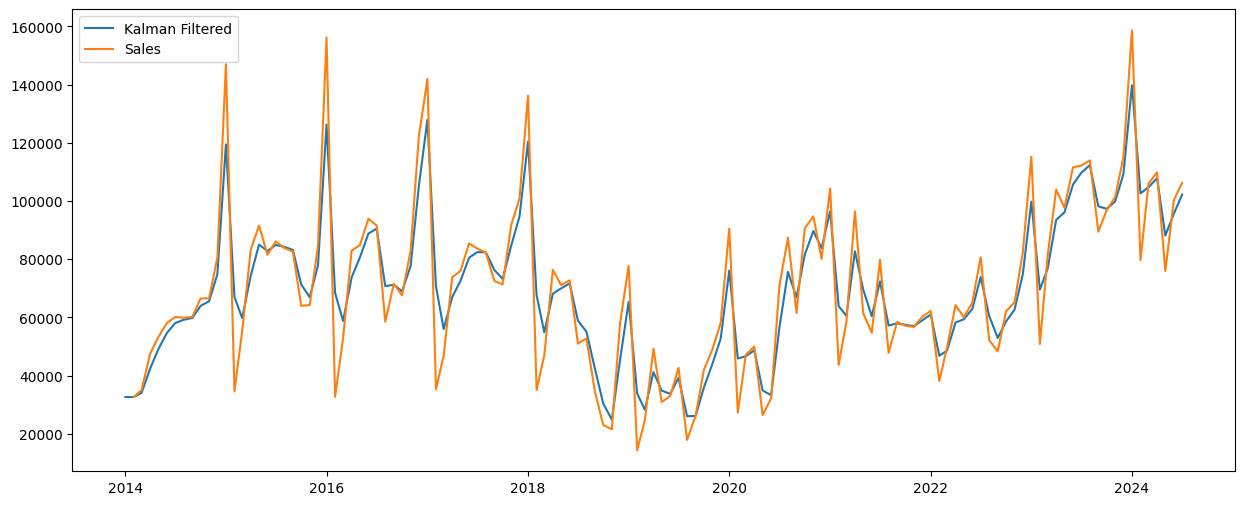

In [24]:
plt.figure(figsize=(15,6))
#plt.plot(monthly_data["Date"],monthly_data["Shifted1"],label = "1 Lagged")
plt.plot(monthly_data["Date"],monthly_data["Kalman_Filtered"],label = "Kalman Filtered")
plt.plot(monthly_data["Date"],monthly_data["Shifted1"],label = "Sales")

plt.legend()
plt.show()

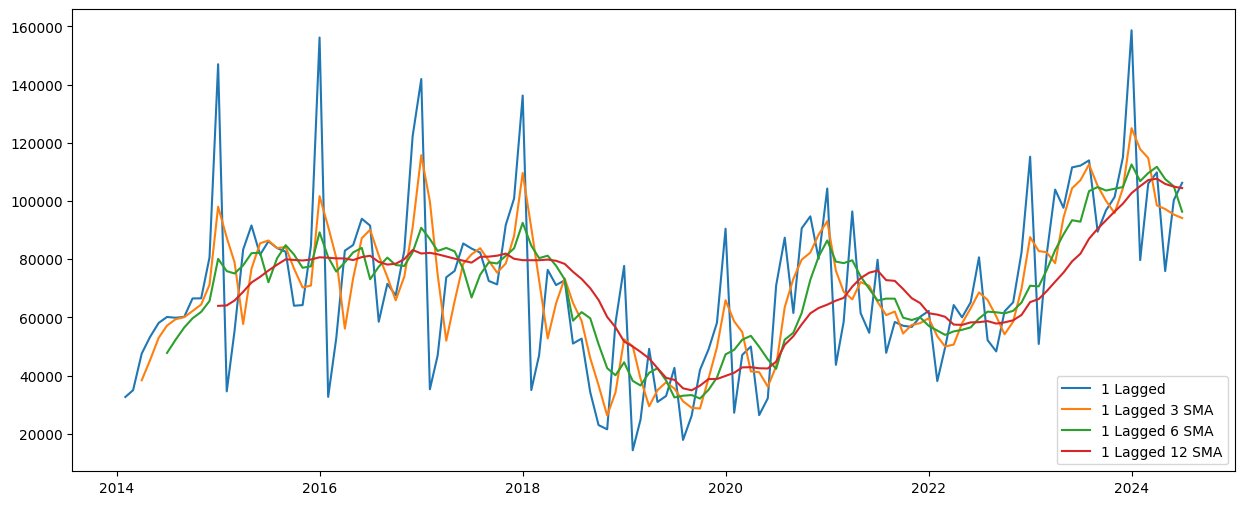

In [29]:
plt.figure(figsize=(15,6))
plt.plot(monthly_data["Date"],monthly_data["Shifted1"],label = "1 Lagged")
plt.plot(monthly_data["Date"],monthly_data["Shifted1_SMA3"],label = "1 Lagged 3 SMA")
plt.plot(monthly_data["Date"],monthly_data["Shifted1_SMA6"],label = "1 Lagged 6 SMA")
plt.plot(monthly_data["Date"],monthly_data["Shifted1_SMA12"],label = "1 Lagged 12 SMA")

plt.legend()
plt.show()

In [25]:
train_set = monthly_data[monthly_data.Date < '2023-11-01']
test_set = monthly_data[monthly_data.Date >= '2023-11-01']
X_Train = train_set.drop(["Date","TTL_TOPLAM"],axis = 1)
X_Test = test_set.drop(["Date","TTL_TOPLAM"],axis = 1)
y_train = train_set["TTL_TOPLAM"]
y_test = test_set["TTL_TOPLAM"]

In [26]:
X_Train

,Shifted1,Shifted3,Shifted6,Shifted12,Shifted1_SMA3,Shifted1_SMA6,Shifted1_SMA12,Month,Quarter,Year,Kalman_Filtered
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2014,32670.000000
1,32670.0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2014,32670.000000
2,35021.0,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2014,34116.769231
3,47581.0,32670.0,NaN,NaN,38424.000000,NaN,NaN,4,2,2014,42432.911765
4,53305.0,35021.0,NaN,NaN,45302.333333,NaN,NaN,5,2,2014,49151.617978
...,...,...,...,...,...,...,...,...,...,...,...
113,111556.0,103929.0,115220.0,80652.0,104388.000000,93404.333333,79269.750000,6,2,2023,105651.322792
114,112163.0,97679.0,50894.0,52206.0,107132.666667,92894.833333,81895.666667,7,3,2023,109675.760630
115,113959.0,111556.0,81148.0,48336.0,112559.333333,103405.666667,87041.750000,8,3,2023,112322.948143
116,89454.0,112163.0,103929.0,62084.0,105192.000000,104790.000000,90468.250000,9,3,2023,98189.160904


In [36]:
iteration = range(100,600,100)
learning_rate = [.001,.01,.1,.2,.3,.5,.7,.85,.90]
depth = [2,4,6]
#l2_leaf_reg = [.1,.2,.3]


best_score = np.inf
best_params = {}

for i in iteration:
    for j in learning_rate:
        for k in depth:
                cb_model = CatBoostRegressor(iterations=i,learning_rate=j,depth=k,verbose=False,random_seed=42)
                cb_model.fit(X_Train,y_train)
                predict = cb_model.predict(X_Test)
                smape_score = mean_absolute_error(predict,y_test)
                #print(mae)

                if smape_score < best_score:
                    best_score = smape_score
                    best_params["iter"] = i
                    best_params["lr"] = j
                    best_params["depth"] = k
                    #best_params["l2_leaf"] = l
                    best_params["score"] = best_score


In [37]:
best_params

{'iter': 100, 'lr': 0.3, 'depth': 2, 'score': 12561.866101858755}

In [38]:
model = CatBoostRegressor(learning_rate = 0.3,depth=2,iterations=100).fit(X_Train, y_train)


y_pred = model.predict(X_Test)
mean_absolute_percentage_error(y_test, y_pred)

0:	learn: 25467.6438682	total: 938us	remaining: 92.9ms
1:	learn: 23336.0178762	total: 1.54ms	remaining: 75.4ms
2:	learn: 21018.2798068	total: 1.85ms	remaining: 59.8ms
3:	learn: 19873.9627706	total: 2.25ms	remaining: 53.9ms
4:	learn: 18562.7306639	total: 2.49ms	remaining: 47.3ms
5:	learn: 17761.1315334	total: 2.87ms	remaining: 44.9ms
6:	learn: 16666.3365124	total: 3.16ms	remaining: 42ms
7:	learn: 15965.1010460	total: 3.46ms	remaining: 39.8ms
8:	learn: 15526.4922265	total: 3.74ms	remaining: 37.8ms
9:	learn: 14916.8457132	total: 3.98ms	remaining: 35.8ms
10:	learn: 14604.9514460	total: 4.27ms	remaining: 34.6ms
11:	learn: 14160.9189799	total: 4.53ms	remaining: 33.2ms
12:	learn: 13748.9992431	total: 4.8ms	remaining: 32.2ms
13:	learn: 13270.4421611	total: 5.09ms	remaining: 31.3ms
14:	learn: 12843.1332077	total: 5.34ms	remaining: 30.3ms
15:	learn: 12656.9778466	total: 5.61ms	remaining: 29.4ms
16:	learn: 12349.6089070	total: 5.83ms	remaining: 28.5ms
17:	learn: 11928.1144049	total: 6.09ms	remain

0.16988451392552445

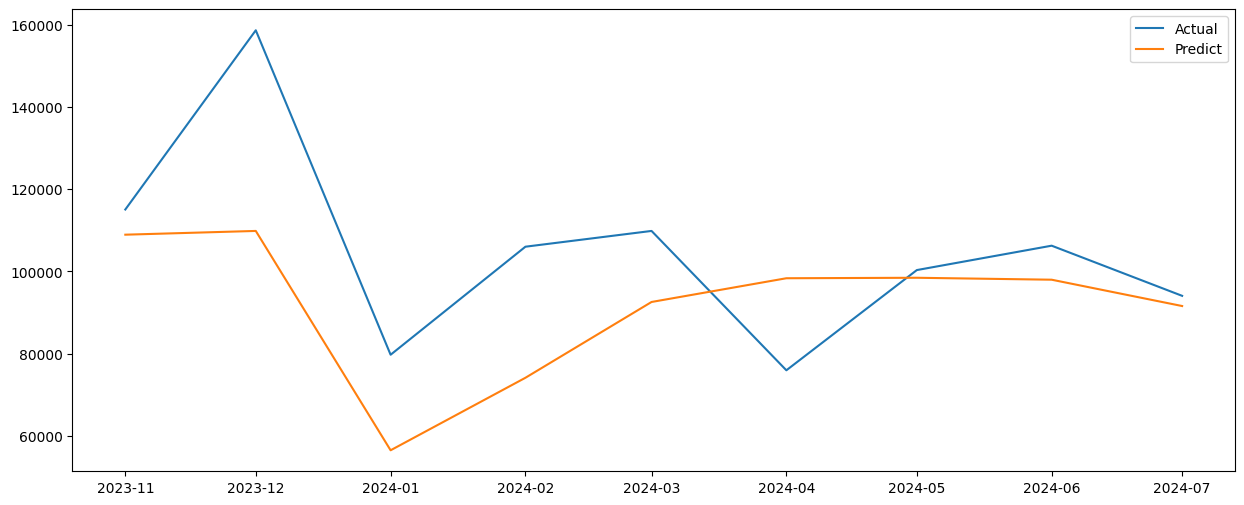

In [39]:
plt.figure(figsize=(15,6))
plt.plot(test_set.Date,y_test,label = "Actual")
plt.plot(test_set.Date,y_pred,label = "Predict")
plt.legend()
plt.show()

In [40]:
X_Train = train_set.set_index("Date")
X_Test = test_set.set_index("Date")
y_train = X_Train["TTL_TOPLAM"]
y_test = X_Test["TTL_TOPLAM"]

X_Train = X_Train.drop("TTL_TOPLAM",axis=1)
X_Test = X_Test.drop("TTL_TOPLAM",axis=1)

In [30]:
arima = sm.tsa.statespace.SARIMAX(y_train,exog=X_Train.fillna(method="bfill"),order=(6,0,0),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=True, enforce_invertibility=True).fit()
arima.summary()


C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             TTL_TOPLAM   No. Observations:                  118
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -1309.820
Date:                Mon, 12 Aug 2024   AIC                           2655.639
Time:                        11:52:43   BIC                           2705.512
Sample:                    01-01-2014   HQIC                          2675.889
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Shifted1            0.6425      1.607      0.400      0.689      -2.508       3.793
Shifted3           -0.3856      0.582     -0.663      0.507      -1.526       0.755
Shifted6            0.3253      0.265      1.226      0.220      -0.195       0.845
Shifted12          -0.1352      0.183     -0.739      0.460      -0.494       0.223
Shifted1_SMA3       0.6237      2.639      0.236      0.813      -4.550       5.797
Shifted1_SMA6       1.1250      0.890      1.264      0.206      -0.620       2.870
Shifted1_SMA12     -0.3021      0.409     -0.739      0.460      -1.103       0.499
Month            1.307e+04   3465.136      3.772      0.000    6277.560    1.99e+04
Quarter         -3.012e+04   1.24e+04     -2.428      0.015   -5.44e+04   -5805.591
Year                2.1069      6.706      0.314      0.753     -11.037      15.251
Kalman_Filtered    -1.0840      4.132     -0.262      0.793      -9.182       7.014
ar.L1               0.0487      0.117      0.417      0.676      -0.180       0.278
ar.L2              -0.0122      0.115     -0.106      0.915      -0.238       0.214
ar.L3               0.1592      0.115      1.380      0.168      -0.067       0.385
ar.L4               0.1308      0.109      1.200      0.230      -0.083       0.344
ar.L5               0.1017      0.115      0.885      0.376      -0.124       0.327
ar.L6              -0.6258      0.159     -3.947      0.000      -0.937      -0.315
sigma2           3.021e+08      0.580   5.21e+08      0.000    3.02e+08    3.02e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.21   Prob(JB):                         0.48
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.53e+25. Standard errors may be unstable.
"""

In [31]:
te_start,te_end = '2023-11-01','2024-07-01'

In [32]:
pred = arima.predict(te_start,te_end,exog = X_Test)


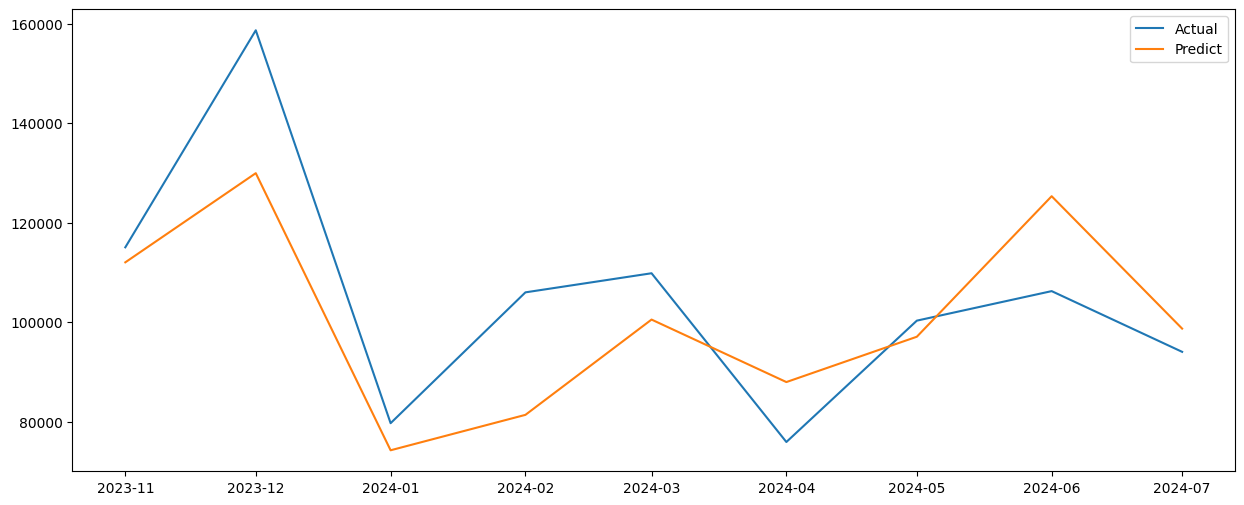

In [33]:
plt.figure(figsize=(15,6))
plt.plot(test_set.Date,y_test,label = "Actual")
plt.plot(test_set.Date,pred,label = "Predict")
plt.legend()
plt.show()

In [34]:
mean_absolute_percentage_error(y_test,pred)

0.11250099867341963

In [35]:
mean_absolute_error(y_test,pred)

12234.560220382296

,Date,TTL_TOPLAM,Shifted1,Shifted3,Shifted6,Shifted12,Shifted1_SMA3,Shifted1_SMA6,Shifted1_SMA12,Month,Quarter,Year,Kalman_Filtered
0,2014-01-01,32670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2014,32670.000000
1,2014-02-01,35021,32670.0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2014,32670.000000
2,2014-03-01,47581,35021.0,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2014,34116.769231
3,2014-04-01,53305,47581.0,32670.0,NaN,NaN,38424.000000,NaN,NaN,4,2,2014,42432.911765
4,2014-05-01,58121,53305.0,35021.0,NaN,NaN,45302.333333,NaN,NaN,5,2,2014,49151.617978
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,2024-03-01,109828,105990.0,158653.0,96793.0,103929.0,114781.333333,109590.666667,107190.333333,3,1,2024,104713.067688
123,2024-04-01,75919,109828.0,79701.0,101367.0,97679.0,98506.333333,111763.166667,107681.916667,4,2,2024,107874.269707
124,2024-05-01,100305,75919.0,105990.0,115040.0,111556.0,97245.666667,107521.833333,105868.583333,5,2,2024,88124.826908
125,2024-06-01,106238,100305.0,109828.0,158653.0,112163.0,95350.666667,105066.000000,104931.000000,6,2,2024,95652.587868


In [47]:
new_columns = monthly_data.columns

In [50]:
a = monthly_data.isna().sum().reset_index()
a.columns = ["column","NA"]

In [52]:
t = test_set[new_columns].reset_index(drop = True)
t = t.rename(columns={"Date":"ds","TTL_TOPLAM":"y"})
t_y = t[["y"]]
t_y.columns = ["y"]

In [83]:
from prophet import Prophet
f = train_set.reset_index(drop= True)
f = f[new_columns]
f = f.rename(columns={"Date":"ds","TTL_TOPLAM":"y"})

for j in a[a.NA > 0]["column"].values:
    f[j] = f[j].fillna(0)


m = Prophet(interval_width=0.95)
m.add_seasonality(name='monthly', period=60.5, fourier_order=5,prior_scale=0.7)


for i in new_columns[2:]:
    print(i," added in Prophet Model.")
    m.add_regressor(i,standardize=True,mode='additive')


m.fit(f)
#forecast = m.predict(t_p)  

12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing


Shifted1  added in Prophet Model.
Shifted3  added in Prophet Model.
Shifted6  added in Prophet Model.
Shifted12  added in Prophet Model.
Shifted1_SMA3  added in Prophet Model.
Shifted1_SMA6  added in Prophet Model.
Shifted1_SMA12  added in Prophet Model.
Month  added in Prophet Model.
Quarter  added in Prophet Model.
Year  added in Prophet Model.
Kalman_Filtered  added in Prophet Model.


In [84]:
forecast = m.predict(t.drop(["y"],axis = 1))

In [85]:
from prophet.plot import plot_plotly
import plotly.offline as py 

fig = plot_plotly(m,forecast)
py.iplot(fig)

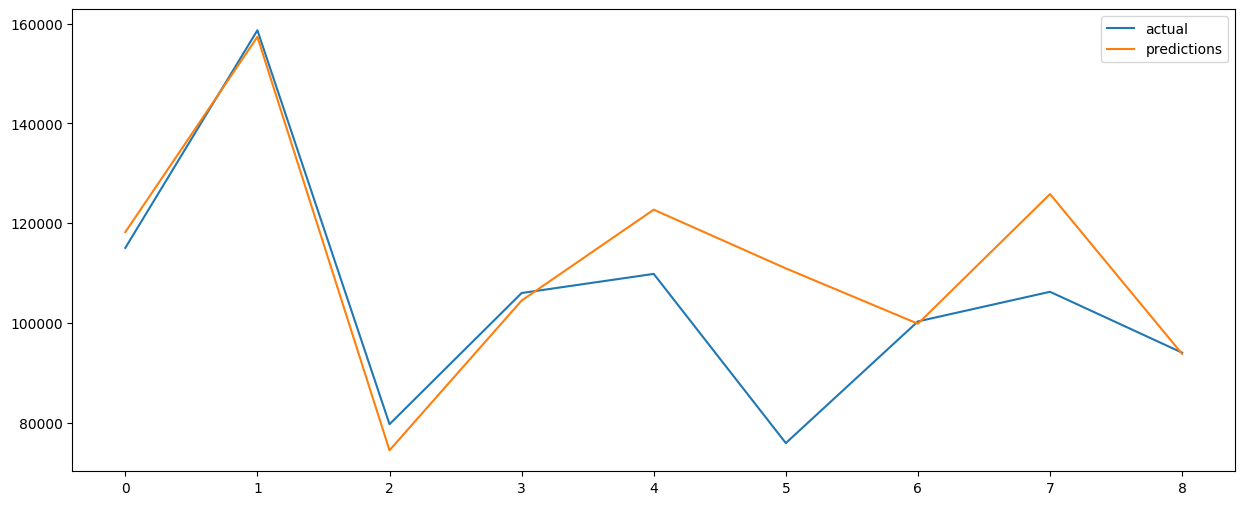

In [86]:
plt.figure(figsize=(15,6))
plt.plot(np.array(y_test), label='actual')
plt.plot(forecast["yhat"], label='predictions')
plt.legend()
plt.show()

In [78]:
mean_absolute_error(y_true=y_test,y_pred=forecast["yhat"])

14895.93037524207

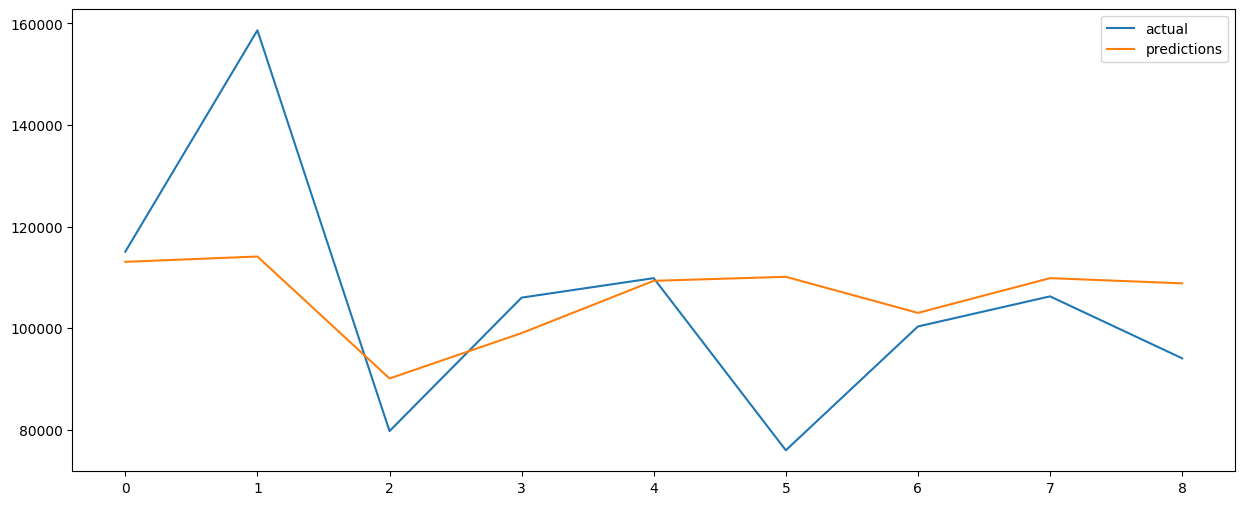

MAE :  13293.983177189748


In [88]:
gbrt = HistGradientBoostingRegressor(loss="quantile",quantile=0.75).fit(X_Train,y_train)
pred = gbrt.predict(X_Test)

plt.figure(figsize=(15,6))
plt.plot(np.array(y_test), label='actual')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()


print("MAE : ",mean_absolute_error(y_true=y_test,y_pred=pred))
